In [1]:
#The notebook I will use to do the Kaggle Titanic competition

In [2]:
#imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import itertools

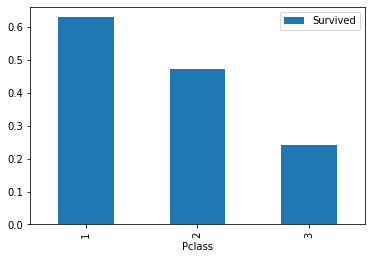

In [3]:
#read data
train = pd.read_csv("titanic/train.csv")
test = pd.read_csv("titanic/test.csv")

gender_pivot = train.pivot_table(index="Sex",values="Survived")
gender_pivot #females survived more than males did

pclass_pivot = train.pivot_table(index="Pclass",values="Survived")
pclass_pivot.plot.bar()
plt.show()

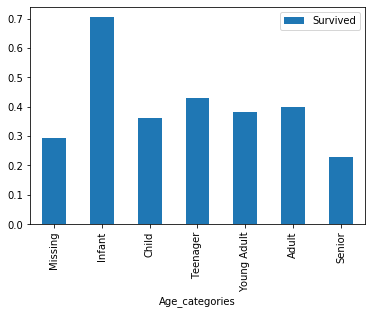

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_categories
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Young Adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Young Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Young Adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Young Adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Young Adult
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Young Adult
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,-0.5,1,2,W./C. 6607,23.4500,NaN,S,Missing
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Young Adult


In [4]:
#looking at and converting the age column
train['Age'].describe()

#survived = train[train["Survived"]==1]
#died = train[train["Survived"]==0]
#survived["Age"].plot.hist(alpha=.5,color='red',bins=50)
#died["Age"].plot.hist(alpha=.5,color='blue',bins=50)
#plt.show()

#can see that in some places, different age groups performed differently,
#should divide it into ranges using pandas.cut()

#need to make the same changes to test and train
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5) #handle the missing values
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

cut_points = [-1,0,5,12,18,35,60,100] #different segments to cut the data into: forms 6 'bins': [-1,0],[0,5] etc
label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"] #after filling in the values, convert them into categories

train = process_age(train,cut_points,label_names)
test = process_age(test,cut_points,label_names)


age_categorie_pivots = train.pivot_table(index="Age_categories",values="Survived")
age_categorie_pivots.plot.bar()
plt.show()
train

In [5]:
#use the create_dummies function to create dummy columns for categories
#like Pclass, where 2 doesn't really mean 1*2, it just means class 2
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

train = create_dummies(train,'Pclass')
test = create_dummies(test,'Pclass')
train = create_dummies(train,'Sex')
test = create_dummies(test,'Sex')
train = create_dummies(train,'Age_categories')
test = create_dummies(test,'Age_categories')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Pclass_3,Sex_female,Sex_male,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,1,0,1,0,0,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,1,0,0,0,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,1,1,0,0,0,0,0,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,1,0,0,0,0,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,1,0,1,0,0,0,0,1,0,0


In [6]:
#using sklearn to fit the data
columns = ['Pclass_1','Pclass_2','Pclass_3','Sex_male','Sex_female',
          'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

holdout = test
all_X = train[columns]
all_Y = train['Survived']
X_train,X_test,Y_train,Y_test = train_test_split(all_X,all_Y,test_size=.2,random_state=0)

In [13]:
#put together the model and make predictions
clf = LogisticRegression()
clf.fit(X_train,Y_train)
predictions = clf.predict(X_test)

SVMclf = svm.SVC(kernel='linear')
SVMclf.fit(X_train,Y_train)
SVMpredictions = SVMclf.predict(X_test)

random_forest_clf = RandomForestClassifier(n_estimators = 10)
random_forest_clf.fit(X_train,Y_train)
random_forest_predictions = random_forest_clf.predict(X_test)

In [15]:
#see the accuracy
accuracy = accuracy_score(Y_test,predictions)
print(accuracy)
SVMaccuracy = accuracy_score(Y_test,SVMpredictions)
print(SVMaccuracy)
random_forest_accuracy = accuracy_score(Y_test,random_forest_predictions)
print(random_forest_accuracy)

#show the confusion matrix
matrix = confusion_matrix(Y_test,predictions)
#pd.DataFrame(matrix,columns=['Survived','Died'], index=[['Survived','Died']])

SVMmatrix = confusion_matrix(Y_test,SVMpredictions)
pd.DataFrame(SVMmatrix,columns=['Survived','Died'], index=[['Survived','Died']])

0.8100558659217877
0.7988826815642458
0.8100558659217877


,Survived,Died
Survived,92,18
Died,18,51


In [20]:
#good chance that our model overfits, want to use cross validation
#to test the model on different splits of the data
#ANDREW NG: split data into lots of different slices, train on those

#common form is k-fold cross validation
new_classifier = LogisticRegression() #new classifier to erase the X_test and stuff, want it to not overfit and do that
scores = cross_val_score(new_classifier,all_X,all_Y,cv=10) #gives 10 different scores
print("logistic: ",np.mean(scores))

#also included different classifiers to cross reference, such as SVM and random forest
SVM_new_classifier = svm.SVC(kernel='linear')
scores = cross_val_score(SVM_new_classifier,all_X,all_Y,cv=10)
print("SVM: ",np.mean(scores))

rf_new_classifier = RandomForestClassifier(n_estimators = 10)
scores = cross_val_score(rf_new_classifier,all_X,all_Y,cv=10)
print('random forest: ',np.mean(scores))

logistic:  0.8024719101123596
SVM:  0.7856304619225968
random forest:  0.7924219725343321


In [10]:
#create a new logistic regression object to predict all of the data
lr = LogisticRegression()
lr.fit(all_X,all_Y)
holdout_predictions = lr.predict(holdout[columns])

In [11]:
#prepare model for submission
holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv('titanic_submission.csv',index=False)